In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn import datasets, preprocessing, model_selection, linear_model
import torch
from torch import nn

torch.manual_seed(42)
np.random.seed(42)

# Introduction to Deep Declarative Networks (DDNs)

> Embed optimization problems inside of neural networks:
> Differentiable Optimization 🤝 Deep Learning

**Sources:** Most of the ressources can be found on the website on the *ANU Computer Vision and Machine Learning* [GitHub repo](https://github.com/anucvml/ddn/wiki/Resources). 
In particular, we use:

1. [Paper](https://arxiv.org/pdf/1909.04866.pdf) *Deep Declarative Networks: A New Hope* by Stephen Gould, Richard Hartley, and Dylan Campbell.
2. [ISAAC Lecture Notes](https://users.cecs.anu.edu.au/~sgould/papers/isaac22-lecture-notes.pdf) by Stephen Gould.
3. [Tutorials](https://nbviewer.jupyter.org/github/anucvml/ddn/tree/master/tutorials/) from the DDNs github repository.

![Declarative node](img/declarative_node.png)

## Goal

We want to use layers in neural networks whose outputs are defined as solutions
to (constrained) optimization problems parametrized by their inputs.

![DDN architecture](img/ddn_architecture.png)

Such layers are commonly referred to as *implicit layers* or *declarative nodes*. This extends the concept of a neural network layer to include, for example, geometric model fitting (relative or absolute pose solvers or bundle adjustment), model-predictive control algorithms, expectation-maximization, matching, optimal transport, and structured prediction solvers.

##  Imparative vs. Declarative Nodes

![Comparison between declarative and imparative nodes](img/declarative_vs_imperative_node.png)

**Imperative node / explicit layer:**
- Classical layer with *explicit input-output relationship* (and parameters $\theta$), i.e., 
$y = \tilde{f}(x;\theta)$.
- Gradients are computed via automatic differentiation (*backpropagation*).

**Declarative node / implicit layer:**
- Input-output relationship specified as *solution to an optimisation problem* (parametrized by the input $x$ and parameters $\theta$), i.e., 
$y \in \operatorname{argmin}_{u\in C(x)} f(x,u;\theta)$.
- Defined in terms of behavior and agnostic to the exact implementation (nomenclature *imperative* and *declarative* is borrowed from the programming languages community).
- Gradients can be computed via *implicit differentiation* (instead of backpropagating through the optimisation procedure).

## Example: Average Pooling

Mapping from a vector $(x_i)_{i=1}^n \in \mathbb{R}^n$ to the *average* $y\in\mathbb{R}$.

**Imperative node**: $y = \frac{1}{n} \sum_{i=1}^n x_i$

**Declarative node**: $y \in \operatorname{argmin}_{u \in \mathbb{R}} \sum_{i=1}^n \phi(u - x_i)$ with $\phi(z)=\frac{1}{2}z^2$.

But...why? 💡 We can easily look at more robust versions of average pooling, e.g., using the *Huber penalty function*

$$\phi_\alpha(z) = \begin{cases} \frac{1}{2}z^2, &|z|\le \alpha \\ \alpha(|z| - \frac{1}{2}\alpha), &\text{else}. \end{cases}$$

Note that the parameter $\alpha$ determines the robustness w.r.t. outliers and interpolates between the median and the arithmetic mean.

Let us visualize the Huber penalty function.

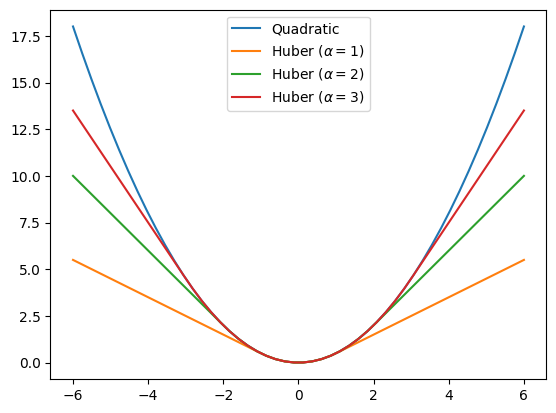

In [2]:
def huber(z, alpha=1):
    return np.where(
        np.abs(z) <= alpha, 0.5 * np.power(z, 2.0), alpha * np.abs(z) - 0.5 * alpha**2
    )


z = np.linspace(-6, 6)
plt.plot(z, 0.5 * z**2, label="Quadratic")
for alpha in [1, 2, 3]:
    plt.plot(z, huber(z, alpha=alpha), label=rf"Huber ($\alpha={alpha}$)")
plt.legend()
plt.show()

### Forward pass

Note that there does not exist a closed-form solution to the optimization problem given by
$$y \in \operatorname{argmin}_{u \in \mathbb{R}^d} \sum_{i=1}^n \phi_\alpha(u - x_i)$$
with $\phi_\alpha$ being the Huber penalty function.
Since the Huber loss is convex, let us find the robust average using L-BFGS-B from `scipy`.

In [3]:
def objective(x, y, alpha=1):
    return np.sum(huber(y - x, alpha=alpha), axis=-1)


# Note that the Huber penalty function is only once continuously differentiable
def dz_huber(z, alpha=1):
    return np.where(np.abs(z) <= alpha, z, alpha * np.sign(z))


def solve(x, alpha=1):
    shape = x.shape
    x = x.reshape(-1, shape[-1])
    fun = lambda y: np.sum(objective(x, np.reshape(y, (-1, 1)), alpha=alpha))
    jac = lambda y: np.sum(dz_huber(np.reshape(y, (-1, 1)) - x, alpha=alpha), axis=-1)
    x0 = np.mean(x, axis=-1)
    result = scipy.optimize.minimize(
        fun, x0, method="L-BFGS-B", options={"maxiter": 100, "disp": False}
    )
    if not result.success:
        print(result.message)
    return result.x.reshape(*shape[:-1], 1)

Let's visualize the forward pass and compare to the standard average, i.e., the arithmetic mean.

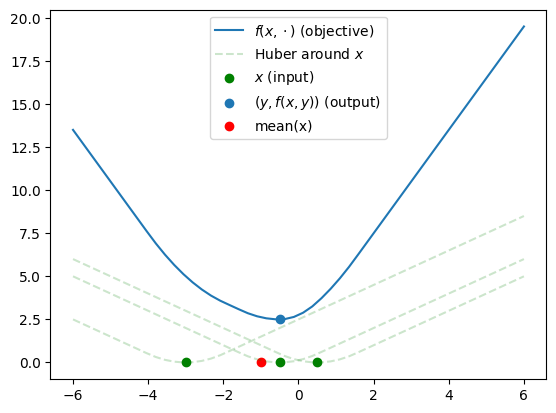

In [4]:
alpha = 1
x = np.array([-3 * alpha, -0.5, 0.5])
# x = np.array([-2*alpha, 2*alpha]) # many non-isolated solutions

y = np.linspace(-6, 6)
plt.plot(
    z, objective(x, y.reshape(-1, 1), alpha=alpha), label=r"$f(x,\cdot)$ (objective)"
)
y_star = solve(x, alpha=1)
for i, xi in enumerate(x):
    plt.plot(
        y,
        huber(y - xi, alpha=alpha),
        "--",
        c="g",
        alpha=0.2,
        label="Huber around $x$" if i == 0 else None,
    )
plt.scatter(x, np.zeros_like(x), label=r"$x$ (input)", c="g")
plt.scatter(y_star, objective(x, y_star, alpha=alpha), label=r"$(y,f(x,y))$ (output)")
plt.scatter(np.mean(x), 0.0, label=r"mean(x)", c="r")
plt.legend()
plt.show()

### Backward pass

Now we want to use the *implicit function theorem* to define a derivative of the declarative robust pooling node.  In doing so, we do not need to explicitly unroll the optimization procedure, making the backward pass 
1. more memory and time efficient,
2. agnostic to the solver used in the forward pass (we just assume it converged to a stationary point).

**Derivation (unconstrained case):** Let $y(x) \in \operatorname{argmin}_{u\in\mathbb{R}} f(x,u)$ and assume that $f$ is second-order differentiable in the neighborhood of $(x,y(x))$. Then, the first-order optimality condition requires that $\delta(x,y)=D_y f(x,y)=0$.
Assuming that $D_x \delta(x,y) \neq 0$, the *implicit function theorem* guarantees that for $\tilde{x}$ sufficiently close to $x$, it holds that $\delta(\tilde{x},y(\tilde{x}))=0$ and $$D_x y(\tilde{x}) = - [D_y \delta(\tilde{x},y(\tilde{x}))]^{-1} D_x \delta(\tilde{x},y(\tilde{x})).$$

**Intuition:** Take the derivative w.r.t. $x$ on both sides of $\delta(\tilde{x},y(\tilde{x}))=0$, i.e.,
$$D_x\delta(\tilde{x},y(\tilde{x})) + D_y\delta(\tilde{x},y(\tilde{x}))D_x y(\tilde{x})=0,$$
and solve for $D_x y$.

**Result:** In particular, replacing the definition of $\delta$, we obtain that
$$D_x y(x) = - [D_{yy} f(x,y)]^{-1} D_{xy} f(x,y).$$

💡 Using *Lagrange multipliers* and *KKT optimality conditions*, one can also obtain closed-form expressions for *(in)equality constrained optimization problems*.

⚠️ Computing $D_x y(x)$ can be costly and requires the Hessian $D_{yy} f(x,y)$ to be invertible (i.e., strong convexity around the solution). 

Let us implement the formula $D_x y(x) = - [D_{yy} f(x,y)]^{-1} D_{xy} f(x,y)$. We switch to `torch` in order to integrate it into a torch module.

In [5]:
def dzz_huber(z, alpha=1):
    return torch.where(z.abs() <= alpha, 1.0, 0.0)


def gradient(x, y, alpha=alpha, eps=1e-4):
    dzz_huber_eval = dzz_huber(y - x, alpha=alpha)
    dyy = dzz_huber_eval.sum(axis=-1, keepdim=True)
    neg_dxy = dzz_huber_eval
    # If dyy is zero, the implicit function theorem does not hold and we set the gradient to zero
    return torch.where(dyy.abs() <= eps, torch.zeros_like(neg_dxy), neg_dxy / dyy)


class RobustPool(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        x = x.detach()
        y = solve(x.cpu().numpy(), alpha=alpha.item())
        y = torch.from_numpy(y).to(x)
        ctx.save_for_backward(x, y, alpha)
        return y

    @staticmethod
    def backward(ctx, grad_output):
        x, y, alpha = ctx.saved_tensors
        grad_input = None
        if ctx.needs_input_grad[0]:
            # Use implicit differentiation to compute derivative
            gradient_eval = gradient(x, y, alpha)
            # Chain rule
            grad_input = gradient_eval * grad_output.detach()
        return grad_input, None, None

### Toy application: Zero-centering

As an example, we can solve the following *bilevel optimization problem*
$$
\min_x |y|^2, \quad \text{s.t.} \quad y\in \operatorname{argmin}_{u\in\mathbb{R}} \sum_{i=1}^n \phi_\alpha(u-x_i),
$$
which updates a set of points $(x_i)_{i=1}^n$ such that their (robust) average moves to zero.

In [6]:
alpha = 1.0
estimators = {
    "mean": lambda x: torch.mean(x, dim=-1),
    "robust average": lambda x: RobustPool.apply(x, torch.tensor(alpha)),
}

results = {}
for name, estimator in estimators.items():
    # Initialize
    x = torch.nn.Parameter(torch.tensor([0.5, -0.2, -1.0, -5]))
    results[name] = [x.data.clone()]
    opt = torch.optim.SGD([x], lr=0.2)
    print(f"--- {name} ---")
    print(f"Initial avg: {estimator(x).item()}")

    # Optimize
    for _ in range(100):
        y = estimator(x)
        loss = y**2
        opt.zero_grad()
        loss.backward()
        opt.step()
        results[name].append(x.data.clone())
    print(f"Final avg: {estimator(x).item()}")

--- mean ---
Initial avg: -1.4249999523162842
Final avg: -3.784894943237305e-05
--- robust average ---
Initial avg: -0.6000000238418579
Final avg: -3.5762786865234375e-07


Let us plot the trajectories of the points and their average during the optimization.

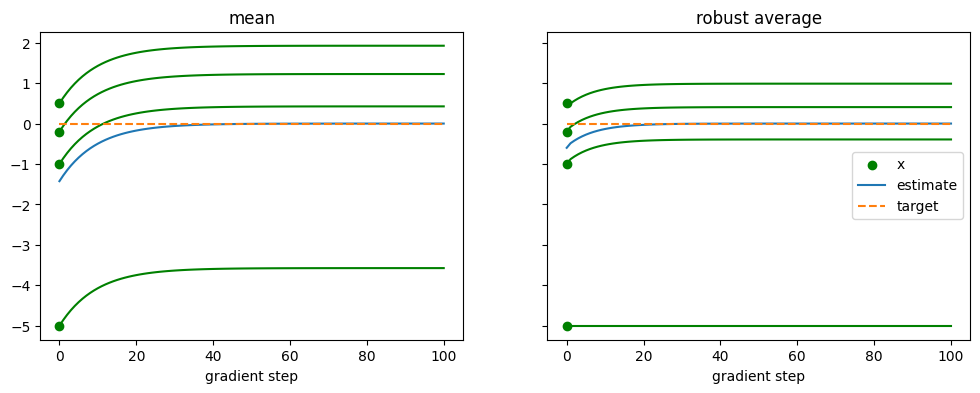

In [7]:
fig, axs = plt.subplots(1, len(results), sharey=True, figsize=(12, 4))
for (name, xt), ax in zip(results.items(), axs):
    ax.set_title(name)
    ax.set_xlabel("gradient step")
    xt = torch.stack(xt, dim=1)
    t = torch.arange(xt.shape[-1])
    for traj in xt:
        ax.plot(t, traj, c="g")
    ax.scatter(torch.zeros_like(x), xt[:, 0], c="g", label="x")
    ax.plot(t, estimators[name](xt.T), label="estimate")
    ax.plot(t, torch.zeros_like(t), "--", label="target")

plt.legend()
plt.show()

### Toy example: Robust ensemble

As another example, we train two neural networks ensembles on the breast cancer wisconsin dataset. One is using an arithmetic mean of models, the other one is using our robust average. Then we test their robustness when setting a fraction of the test features to a standard normal.

In [8]:
# Read data and preprocess
x, y = datasets.load_breast_cancer(return_X_y=True)
y = torch.from_numpy(y).reshape(-1, 1).float()
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x, y, train_size=0.7, shuffle=True
)
scaler = preprocessing.StandardScaler().fit(x_train)
x_train, x_test = scaler.transform(x_train), scaler.transform(x_test)
x_train, x_test = torch.from_numpy(x_train).float(), torch.from_numpy(x_test).float()

# Eraze features in test dataset
n_random = 15
for i in range(len(x_test)):
    idx = torch.randperm(x_test.shape[-1])[:n_random]
    x_test[i, idx] = torch.randn(len(idx))


class Ensemble(nn.Module):
    def __init__(self, n_features, n_models=10, width=64, alpha=None):
        super().__init__()
        self.models = torch.nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(n_features, width),
                    nn.ReLU(),
                    nn.Linear(width, 1),
                    nn.Sigmoid(),
                )
                for _ in range(n_models)
            ]
        )
        if alpha is not None:
            self.register_buffer("alpha", torch.tensor([alpha]))
        else:
            self.alpha = None

    def forward(self, x):
        x = torch.cat([model(x) for model in self.models], dim=-1)
        if self.alpha is not None:
            return RobustPool.apply(x, self.alpha).clip(0.,1.)
        return x.mean(dim=-1, keepdim=True)    

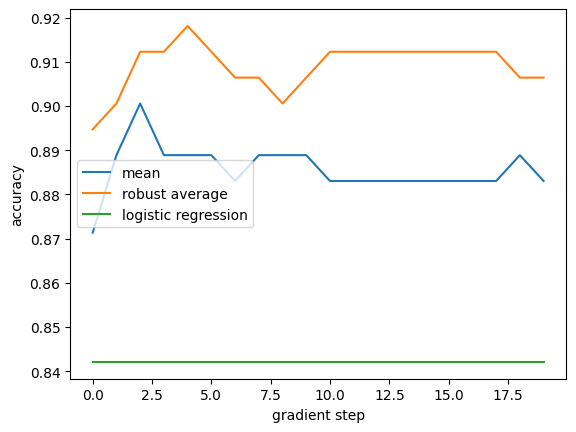

In [9]:
def model_train(model, x_train, y_train, x_test, y_test, n_epochs=20, batch_size=128):
    accs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(n_epochs):
        model.train()
        for start in torch.arange(0, len(x_train), batch_size):
            x_batch = x_train[start : start + batch_size]
            y_batch = y_train[start : start + batch_size]
            loss = nn.BCELoss()(model(x_batch), y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        y_pred = model(x_test)
        accs.append((y_pred.round() == y_test).float().mean().item())
    return accs


net = Ensemble(n_features=x_train.shape[-1])
robust_net = Ensemble(n_features=x_train.shape[-1], alpha=0.01)
linear = linear_model.LogisticRegression()

accs = model_train(net, x_train, y_train, x_test, y_test)
robust_accs = model_train(robust_net, x_train, y_train, x_test, y_test)
linear.fit(x_train, y_train.squeeze())
linear_acc = linear.score(x_test, y_test.squeeze())

plt.plot(accs, label="mean")
plt.plot(robust_accs, label="robust average")
plt.plot([linear_acc] * len(accs), label="logistic regression")
plt.ylabel("accuracy")
plt.xlabel("gradient step")
plt.legend()
plt.show()

### Experiments 

Robust pooling layers have significantly improved point cloud classification results for the ModelNet40 dataset, with varying percentages of outliers (O) and no outliers seen during training, see the [paper by Gould, Hartley, and Campbell](https://arxiv.org/pdf/1909.04866.pdf). PointNet is compared to variants that replace max pooling with robust pooling: quadratic (Q), pseudo-Huber (PH), Huber (H), Welsch (W), and truncated quadratic (TQ), all trained from scratch.

![Results](img/results.png)

## Outlook

DDNs are an active area of research and pose many open questions:

1. Speed and performance tradeoffs:
    - declarative vs. imparative nodes
    - effect of suboptimal solutions (e.g., when stopping the solver before convergence)
2. Behavior of DDNs:
    - guarantees of declarative nodes (via guarantees of the corresponding solvers)
    - robustness and generalization (especially in the low data regime)
    - parametrizations to avoid infeasible optimization problems 
4. Extensions and novel applications:
    - problems that cannot be tackled by imparative networks
    - extensions to non-smooth and discrete optimization problems